In [1]:
import yaml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from hyperparam_scan_util import GridScan
pd.set_option('display.max_columns', None)

In [13]:
scan = GridScan.load("main_v2.1", root="results")

df_filename = "analysis.parquet"

# Comment this out if you don't need to reload and export the trials
# scan.export_trials_df(df_filename, loading_progress=True)

trials_df = scan.load_exported_trials_df(df_filename)
trials_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118 entries, 0 to 117
Columns: 125 entries, run_id to metrics.train_time_std
dtypes: bool(1), float64(91), int64(27), object(6)
memory usage: 114.6+ KB


In [14]:
trials_df.head()

,run_id,config_hash,started_at,finished_at,duration,error,config.device_count,config.seed,config.tau,config.I0,config.eps,config.Nout,config.w_scale,config.T,config.K,config.dt,config.gamma,config.Nbatch,config.lr,config.tau_lr,config.beta1,config.beta2,config.p_flip,config.Nepochs,config.Ntrain,config.Nin,config.Nsamples,config.normalize_times,config.Nin_virtual,config.Nhidden,config.Nlayer,metrics.acc_init_mean,metrics.acc_init_std,metrics.acc_final_mean,metrics.acc_final_std,metrics.acc_min_epoch,metrics.acc_min_mean,metrics.acc_min_std,metrics.acc_max_epoch,metrics.acc_max_mean,metrics.acc_max_std,metrics.acc_ord_init_mean,metrics.acc_ord_init_std,metrics.acc_ord_final_mean,metrics.acc_ord_final_std,metrics.acc_ord_min_epoch,metrics.acc_ord_min_mean,metrics.acc_ord_min_std,metrics.acc_ord_max_epoch,metrics.acc_ord_max_mean,metrics.acc_ord_max_std,metrics.activity_init_mean,metrics.activity_init_std,metrics.activity_final_mean,metrics.activity_final_std,metrics.activity_min_epoch,metrics.activity_min_mean,metrics.activity_min_std,metrics.activity_max_epoch,metrics.activity_max_mean,metrics.activity_max_std,metrics.activity_first_init_mean,metrics.activity_first_init_std,metrics.activity_first_final_mean,metrics.activity_first_final_std,metrics.activity_first_min_epoch,metrics.activity_first_min_mean,metrics.activity_first_min_std,metrics.activity_first_max_epoch,metrics.activity_first_max_mean,metrics.activity_first_max_std,metrics.epoch_time_mean,metrics.epoch_time_std,metrics.init_compile_time_mean,metrics.init_compile_time_std,metrics.init_optim_time_mean,metrics.init_optim_time_std,metrics.init_phi0_time_mean,metrics.init_phi0_time_std,metrics.init_time_mean,metrics.init_time_std,metrics.init_weights_time_mean,metrics.init_weights_time_std,metrics.loss_init_mean,metrics.loss_init_std,metrics.loss_final_mean,metrics.loss_final_std,metrics.loss_min_epoch,metrics.loss_min_mean,metrics.loss_min_std,metrics.loss_max_epoch,metrics.loss_max_mean,metrics.loss_max_std,metrics.loss_ord_init_mean,metrics.loss_ord_init_std,metrics.loss_ord_final_mean,metrics.loss_ord_final_std,metrics.loss_ord_min_epoch,metrics.loss_ord_min_mean,metrics.loss_ord_min_std,metrics.loss_ord_max_epoch,metrics.loss_ord_max_mean,metrics.loss_ord_max_std,metrics.silent_neurons_init_mean,metrics.silent_neurons_init_std,metrics.silent_neurons_final_mean,metrics.silent_neurons_final_std,metrics.silent_neurons_min_epoch,metrics.silent_neurons_min_mean,metrics.silent_neurons_min_std,metrics.silent_neurons_max_epoch,metrics.silent_neurons_max_mean,metrics.silent_neurons_max_std,metrics.silent_neurons_first_init_mean,metrics.silent_neurons_first_init_std,metrics.silent_neurons_first_final_mean,metrics.silent_neurons_first_final_std,metrics.silent_neurons_first_min_epoch,metrics.silent_neurons_first_min_mean,metrics.silent_neurons_first_min_std,metrics.silent_neurons_first_max_epoch,metrics.silent_neurons_first_max_mean,metrics.silent_neurons_first_max_std,metrics.train_time_mean,metrics.train_time_std
0,20240916_163932,010e8f7be35c9cd1a6b1ac6baf4911b1,2024-09-16_17-28-41_762508,2024-09-16_17-32-19_396864,217.634356,None,1,0,1.909859,1.25,0.000001,20,0.5,2.0,300,0.001,0.01,1000,0.004,100.0,0.9,0.999,0.0,100,None,700,3,True,80,200,2,0.054670,0.004367,0.043007,0.003819,91,0.041458,0.002190,7,0.435478,0.015186,0.044865,0.001159,0.043007,0.003819,91,0.041458,0.002190,7,0.219778,0.016419,0.321236,0.003951,0.000000,0.000000,10,0.000000,0.000000,1,0.498666,0.029499,0.321236,0.003951,0.000000,0.000000,10,0.000000,0.000000,1,0.457515,0.027189,0.664522,0.003327,0.000659,0.000025,0.001936,0.000206,0.000492,0.000018,4.231795,3.353264,0.000886,0.000028,3.048232,0.013490,NaN,NaN,7,1.800745,0.035078,0,3.048232,0.013490,3.012916,0.0,3.012916,0.000000,2,2.947631,0.023225,0,3.012916,0.0,0.150000,0.033417,1.000000,0.000000,0,0.150000,0.033417,10,1.000000,0.000000,0.150000,0.033417,1.000000,0.000000,0,0.150000,0.033417,10,1.000000,0.000000,66.452225,0.332745
1,20240916_165958,01b7ea6

## Error Summary

In [15]:
n_error = trials_df["error"].notna().sum()
print(f"{n_error} / {len(trials_df)} trials contain errors")
print()

for i, error in enumerate(trials_df["error"].dropna().sort_values().unique()):
    short_error = str(error).split("---", 1)[0].strip().split("\n")[-1]
    print(short_error)
    trials = trials_df[trials_df["error"] == error]
    print(f"Appears in {len(trials)} trials: {trials['config_hash'].tolist()}")
    print()

0 / 118 trials contain errors



In [16]:
def key_format(key: str):
    return key.removeprefix("config.").removeprefix("metrics.")


indep_keys = tuple(
    key for key in trials_df.columns
    if key.startswith("config.") and key != "config.Nin"
)
print("independent keys:", indep_keys)

independent keys: ('config.device_count', 'config.seed', 'config.tau', 'config.I0', 'config.eps', 'config.Nout', 'config.w_scale', 'config.T', 'config.K', 'config.dt', 'config.gamma', 'config.Nbatch', 'config.lr', 'config.tau_lr', 'config.beta1', 'config.beta2', 'config.p_flip', 'config.Nepochs', 'config.Ntrain', 'config.Nsamples', 'config.normalize_times', 'config.Nin_virtual', 'config.Nhidden', 'config.Nlayer')


## Dependencies on `Nin_virtual`

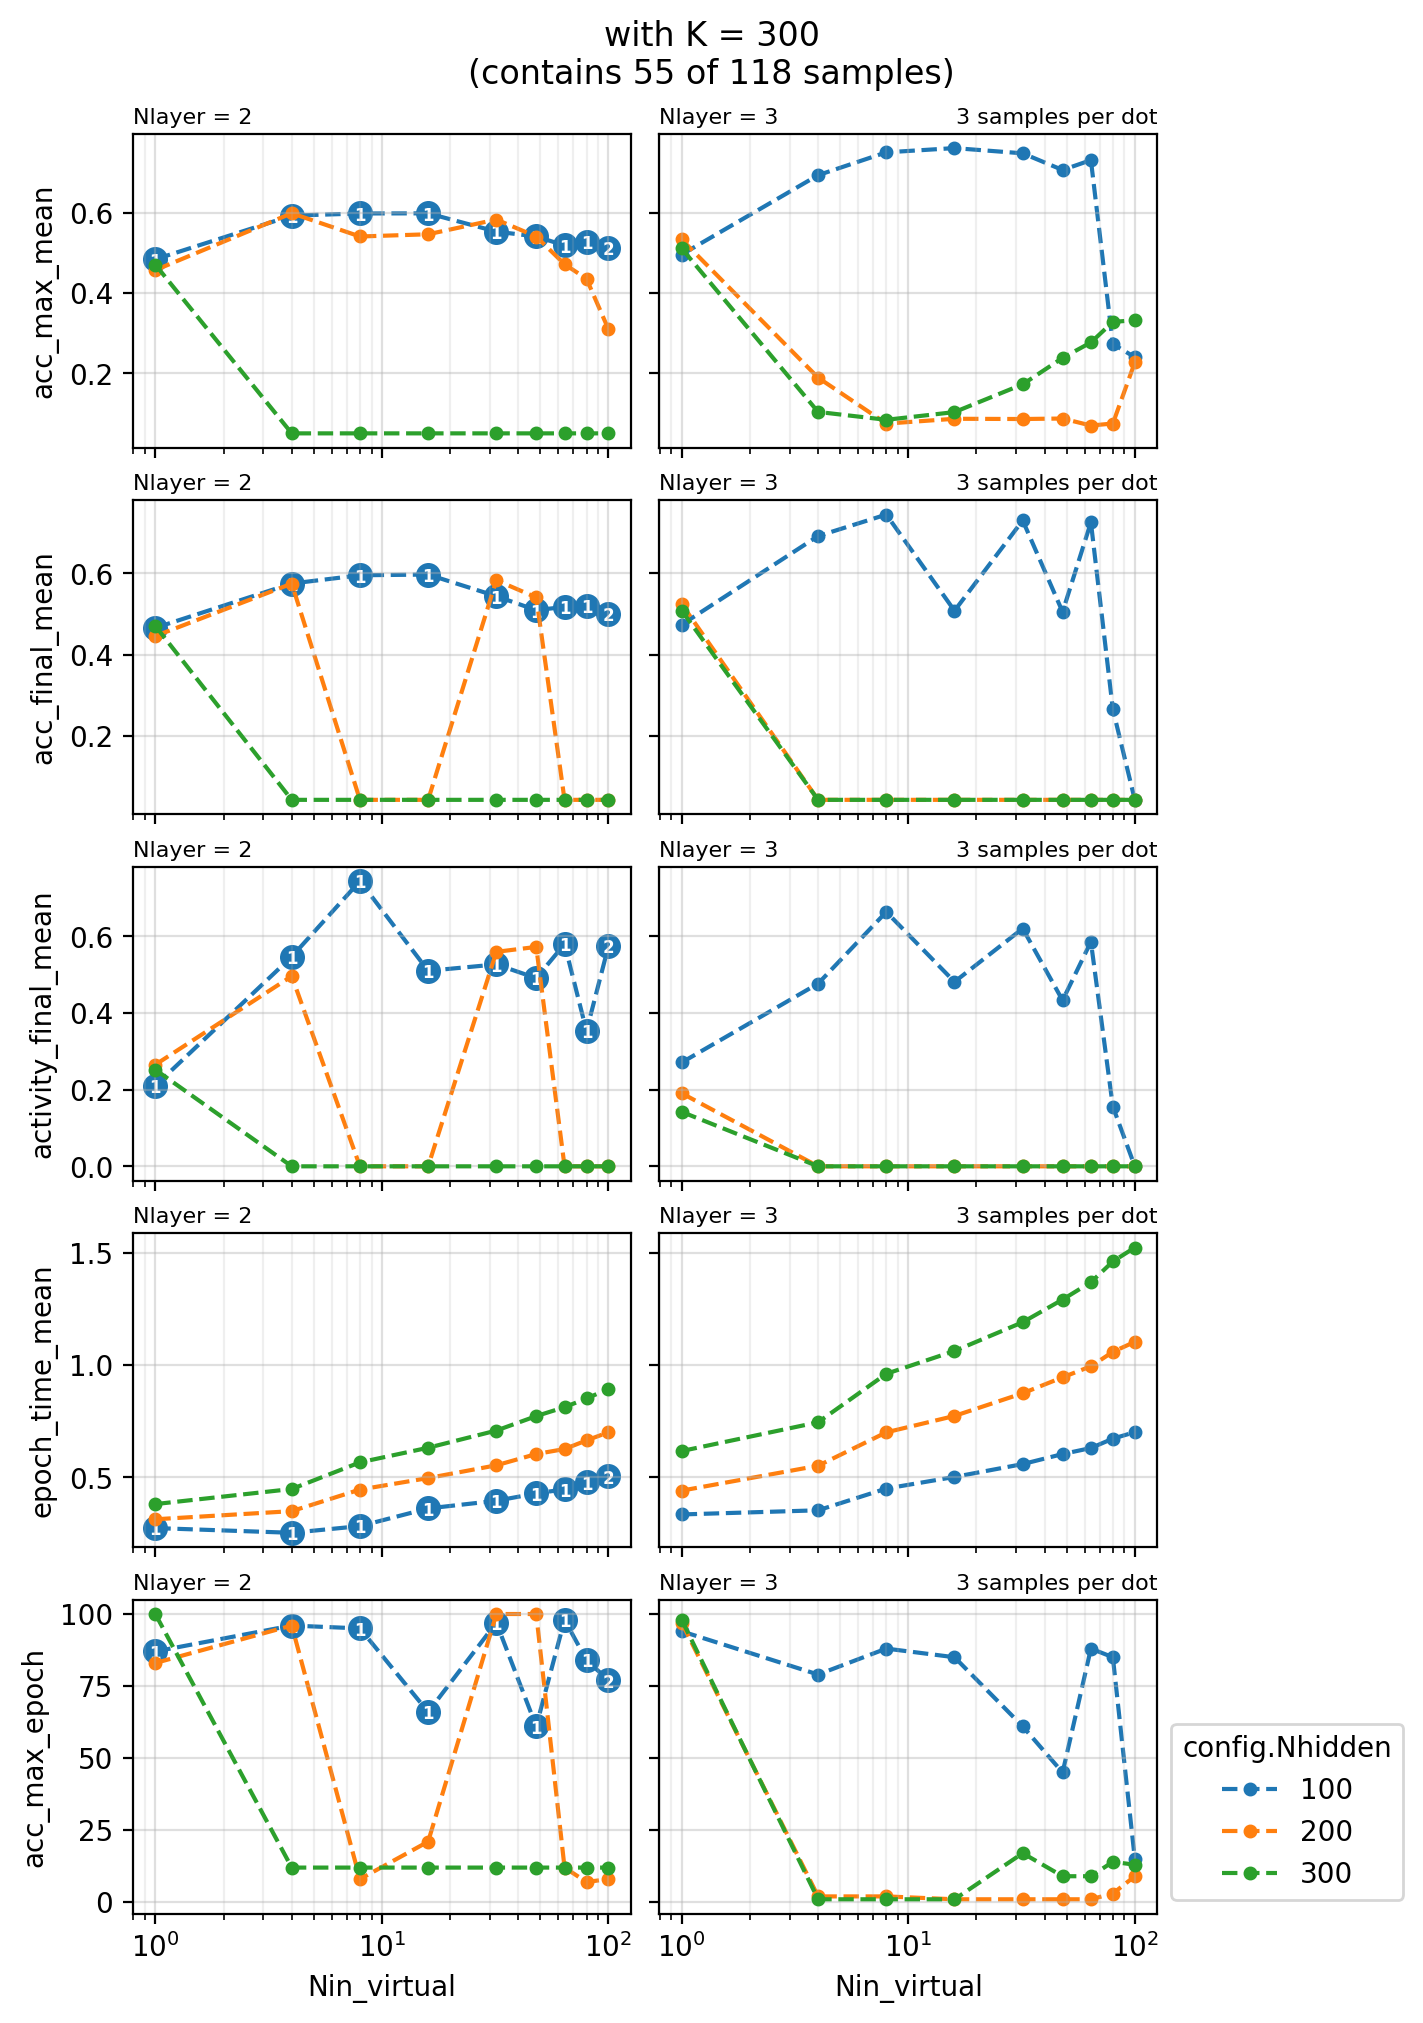

In [17]:
from spikegd.utils.plotting import LinePlot, PlotGrid

PlotGrid(
    arg_keys=("config.Nin_virtual",),
    func_keys=(
        "metrics.acc_max_mean",
        "metrics.acc_final_mean",
        "metrics.activity_final_mean",
        "metrics.epoch_time_mean",
        "metrics.acc_max_epoch"
    ),
    plot_type=LinePlot(
        graph_key="config.Nhidden",
        x_scale="log",
    ),
    col_key="config.Nlayer",
    fixed_values={"config.K": 300},
    # whitelists={"config.Nt": [8, 12, 16]},    
    indep_keys=indep_keys,
    key_format=key_format,
).show(trials_df)

## Best trials

In [18]:
trials_df.sort_values("metrics.acc_max_mean", ascending=False).head(10)

,run_id,config_hash,started_at,finished_at,duration,error,config.device_count,config.seed,config.tau,config.I0,config.eps,config.Nout,config.w_scale,config.T,config.K,config.dt,config.gamma,config.Nbatch,config.lr,config.tau_lr,config.beta1,config.beta2,config.p_flip,config.Nepochs,config.Ntrain,config.Nin,config.Nsamples,config.normalize_times,config.Nin_virtual,config.Nhidden,config.Nlayer,metrics.acc_init_mean,metrics.acc_init_std,metrics.acc_final_mean,metrics.acc_final_std,metrics.acc_min_epoch,metrics.acc_min_mean,metrics.acc_min_std,metrics.acc_max_epoch,metrics.acc_max_mean,metrics.acc_max_std,metrics.acc_ord_init_mean,metrics.acc_ord_init_std,metrics.acc_ord_final_mean,metrics.acc_ord_final_std,metrics.acc_ord_min_epoch,metrics.acc_ord_min_mean,metrics.acc_ord_min_std,metrics.acc_ord_max_epoch,metrics.acc_ord_max_mean,metrics.acc_ord_max_std,metrics.activity_init_mean,metrics.activity_init_std,metrics.activity_final_mean,metrics.activity_final_std,metrics.activity_min_epoch,metrics.activity_min_mean,metrics.activity_min_std,metrics.activity_max_epoch,metrics.activity_max_mean,metrics.activity_max_std,metrics.activity_first_init_mean,metrics.activity_first_init_std,metrics.activity_first_final_mean,metrics.activity_first_final_std,metrics.activity_first_min_epoch,metrics.activity_first_min_mean,metrics.activity_first_min_std,metrics.activity_first_max_epoch,metrics.activity_first_max_mean,metrics.activity_first_max_std,metrics.epoch_time_mean,metrics.epoch_time_std,metrics.init_compile_time_mean,metrics.init_compile_time_std,metrics.init_optim_time_mean,metrics.init_optim_time_std,metrics.init_phi0_time_mean,metrics.init_phi0_time_std,metrics.init_time_mean,metrics.init_time_std,metrics.init_weights_time_mean,metrics.init_weights_time_std,metrics.loss_init_mean,metrics.loss_init_std,metrics.loss_final_mean,metrics.loss_final_std,metrics.loss_min_epoch,metrics.loss_min_mean,metrics.loss_min_std,metrics.loss_max_epoch,metrics.loss_max_mean,metrics.loss_max_std,metrics.loss_ord_init_mean,metrics.loss_ord_init_std,metrics.loss_ord_final_mean,metrics.loss_ord_final_std,metrics.loss_ord_min_epoch,metrics.loss_ord_min_mean,metrics.loss_ord_min_std,metrics.loss_ord_max_epoch,metrics.loss_ord_max_mean,metrics.loss_ord_max_std,metrics.silent_neurons_init_mean,metrics.silent_neurons_init_std,metrics.silent_neurons_final_mean,metrics.silent_neurons_final_std,metrics.silent_neurons_min_epoch,metrics.silent_neurons_min_mean,metrics.silent_neurons_min_std,metrics.silent_neurons_max_epoch,metrics.silent_neurons_max_mean,metrics.silent_neurons_max_std,metrics.silent_neurons_first_init_mean,metrics.silent_neurons_first_init_std,metrics.silent_neurons_first_final_mean,metrics.silent_neurons_first_final_std,metrics.silent_neurons_first_min_epoch,metrics.silent_neurons_first_min_mean,metrics.silent_neurons_first_min_std,metrics.silent_neurons_first_max_epoch,metrics.silent_neurons_first_max_mean,metrics.silent_neurons_first_max_std,metrics.train_time_mean,metrics.train_time_std
45,20240916_203048,6b8c41ae76f2ab49101f678f4b767034,2024-09-16_20-53-12_379759,2024-09-16_21-08-52_933877,940.554118,None,1,0,1.909859,1.25,0.000001,20,0.5,2.0,1000,0.001,0.01,1000,0.004,100.0,0.9,0.999,0.0,100,None,700,3,True,8,300,3,0.047556,0.003208,0.778791,0.014775,0,0.047556,0.003208,71,0.797226,0.006761,0.044865,0.001159,0.201707,0.013334,1,0.044246,0.00191,94,0.210646,0.016200,0.155711,0.007308,0.484834,0.047369,0,0.155711,0.007308,51,0.492652,0.039422,0.155711,0.007308,0.482704,0.047059,0,0.155711,0.007308,51,0.491394,0.039237,3.074913,0.007451,0.000594,0.000003,0.002286,0.000031,0.000688,0.000130,4.623029,3.368241,0.001411,0.000193,3.036116,0.002655,0.871603,0.043885,37,0.800668,0.011060,0,3.036116,0.002655,3.012916,0.0,2.993372,0.003049,3,2.966509,0.004554,0,3.012916,0.0,0.582778,0.009061,0.315000,0.010274,94,0.298889,0.018774,0,0.582778,0.009061,0.582778,0.009061,0.318889,0.009558,60,0.304444,0.043040,0,0.582778,0.009061,307.491272,0.745106
4,20240916_16

In [19]:
best_trial = trials_df.loc[trials_df["metrics.acc_max_mean"].idxmax()]
print("===== BEST TRIAL =====")
print(best_trial[[
    "config_hash", "duration",
    *indep_keys,
    "metrics.acc_max_mean", "metrics.acc_max_std", "metrics.acc_max_epoch"
]])

===== BEST TRIAL =====
config_hash               6b8c41ae76f2ab49101f678f4b767034
duration                                        940.554118
config.device_count                                      1
config.seed                                              0
config.tau                                        1.909859
config.I0                                             1.25
config.eps                                        0.000001
config.Nout                                             20
config.w_scale                                         0.5
config.T                                               2.0
config.K                                              1000
config.dt                                            0.001
config.gamma                                          0.01
config.Nbatch                                         1000
config.lr                                            0.004
config.tau_lr                                        100.0
config.beta1                     

===== BEST TRIAL 0 =====
CONFIG
- device_count            1
- seed                    0
- tau                     1/6 pi^-1
- I0                      1.25
- eps                     1e-06
- Nout                    20
- w_scale                 0.5
- T                       2
- K                       1000
- dt                      0.001
- gamma                   0.01
- Nbatch                  1000
- lr                      0.004
- tau_lr                  100
- beta1                   0.9
- beta2                   0.999
- p_flip                  0
- Nepochs                 100
- Ntrain                  None
- Nin                     700
- Nsamples                3
- normalize_times         1
- Nin_virtual             8
- Nhidden                 300
- Nlayer                  3
METRICS
- acc_init                      0.0476 ± 0.0032
- acc_final                     0.7788 ± 0.0148
- acc_min                       0.0476 ± 0.0032 at epoch 0
- acc_max                       0.7972 ± 0.0068 at ep

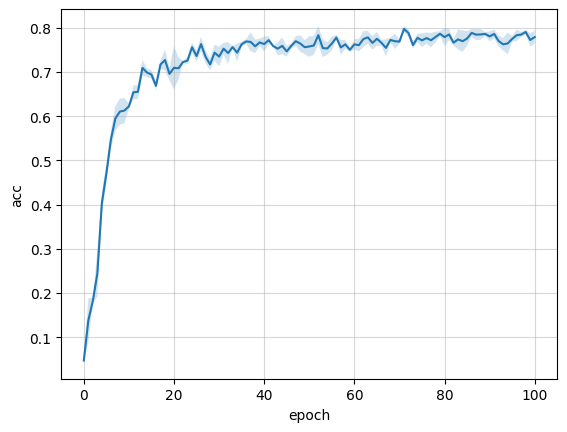

===== BEST TRIAL 1 =====
CONFIG
- device_count            1
- seed                    0
- tau                     1/6 pi^-1
- I0                      1.25
- eps                     1e-06
- Nout                    20
- w_scale                 0.5
- T                       2
- K                       500
- dt                      0.001
- gamma                   0.01
- Nbatch                  1000
- lr                      0.004
- tau_lr                  100
- beta1                   0.9
- beta2                   0.999
- p_flip                  0
- Nepochs                 100
- Ntrain                  None
- Nin                     700
- Nsamples                3
- normalize_times         1
- Nin_virtual             16
- Nhidden                 200
- Nlayer                  3
METRICS
- acc_init                      0.0521 ± 0.0008
- acc_final                     0.7709 ± 0.0110
- acc_min                       0.0521 ± 0.0008 at epoch 0
- acc_max                       0.7906 ± 0.0109 at ep

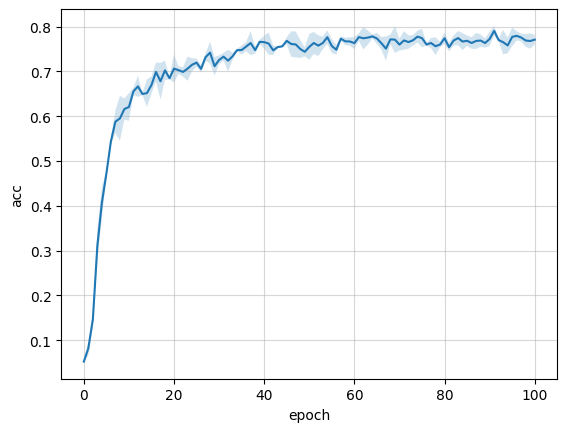

===== BEST TRIAL 2 =====
CONFIG
- device_count            1
- seed                    0
- tau                     1/6 pi^-1
- I0                      1.25
- eps                     1e-06
- Nout                    20
- w_scale                 0.5
- T                       2
- K                       1000
- dt                      0.001
- gamma                   0.01
- Nbatch                  1000
- lr                      0.004
- tau_lr                  100
- beta1                   0.9
- beta2                   0.999
- p_flip                  0
- Nepochs                 100
- Ntrain                  None
- Nin                     700
- Nsamples                3
- normalize_times         1
- Nin_virtual             16
- Nhidden                 300
- Nlayer                  3
METRICS
- acc_init                      0.0476 ± 0.0032
- acc_final                     0.7725 ± 0.0339
- acc_min                       0.0476 ± 0.0032 at epoch 0
- acc_max                       0.7836 ± 0.0186 at e

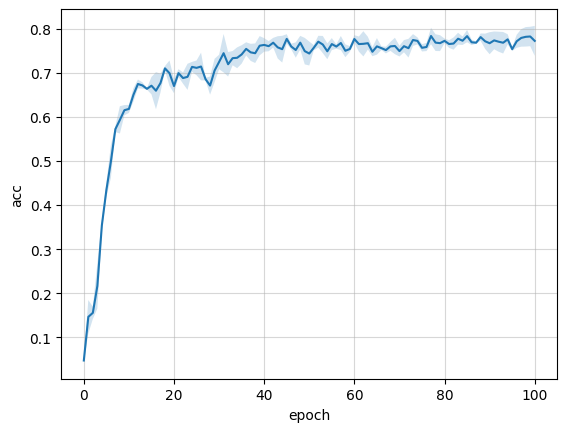

In [20]:
from spikegd.utils.formatting import print_dict

def plot_training_curves(config_hash, metric="acc"):
    trial = scan.load_trial(config_hash)
    epoch_metrics: list = trial.metrics["epochs"]
    
    epochs = np.arange(len(epoch_metrics))
    mean = np.array([metrics[f"{metric}_mean"] for metrics in epoch_metrics])
    std = np.array([metrics[f"{metric}_std"] for metrics in epoch_metrics])

    na_count = np.isnan(mean).sum()
    if na_count > 0:
        print(f"Warning: {na_count} NaN values in {metric}_mean")
    
    fig, ax = plt.subplots()

    ax.plot(epochs, mean)
    ax.fill_between(epochs, mean - std, mean + std, alpha=0.2)

    ax.set_xlabel("epoch")
    ax.set_ylabel(metric)
    ax.grid(alpha=0.5)

    plt.show()

def summarize_trial(trial_row):
    print("CONFIG")
    print_dict(
        {
            "- " + key.removeprefix("config."): value
            for key, value in trial_row.items()
            if key.startswith("config.")
        }
    )
    print("METRICS")

    def summarize_metric(mean_key):
        std_key = mean_key.replace("_mean", "_std")
        epoch_key = mean_key.replace("_mean", "_epoch")

        s = f"{trial_row[mean_key]:.4f}"

        if std_key in trial_row:
            s += f" ± {trial_row[std_key]:.4f}"

        if epoch_key in trial_row:
            s += f" at epoch {trial_row[epoch_key]:.0f}"

        return s

    print_dict(
        {
            "- " + key.removeprefix("metrics.").removesuffix("_mean"): summarize_metric(key)
            for key, value in trial_row.items()
            if key.startswith("metrics.") and key.endswith("_mean")
        },
        indent=32,
    )

best_trials = trials_df \
    .sort_values("metrics.acc_max_mean", ascending=False, ignore_index=True) \
    .head(3)

for i, best_trial in best_trials.iterrows():
    print(f"===== BEST TRIAL {i} =====")
    # print(f"Max accuracy: {best_trial['metrics.acc_max_mean']:.4f} ± {best_trial['metrics.acc_max_std']:.4f} at epoch {best_trial['metrics.acc_max_epoch']}")
    summarize_trial(best_trial)
    plot_training_curves(best_trial["config_hash"])